# Overview
A conceptual model for the problem would be:
\begin{array}{rl}
    \text{min} & \text{unused volume in used bins} \\
    \text{subject to}   & \text{all items assigned to one and only one bin} \\
                        & \text{all items within the bin dimensions} \\
                        & \text{no overlaps between items in the same bin} \\
                        & \text{all items with support} \\
\end{array}

The model also need to account for 90° rotations on the same plane which can be modeled as swapping its width and depth.

# MILP Model
## Sets
\begin{array}{rl}
    I = \{1 \dots n \} & \text{set of items} \\
    J = \{1 \dots m \} & \text{set of homogenous bins} \\
\end{array}

## Parameters
\begin{array}{rll}
    W \times D \times H & \text{width $\times$ depth $\times$ height of a bin} & \\
    V & \text{bin volume} & \\
    w_i \times d_i \times h_i & \text{width $\times$ depth $\times$ height of an item} & \forall i \in I\\
    \alpha_s & \text{support coefficient} & \\
    \beta_s & \text{support tollerance} & \\
\end{array}

## Variables
\begin{array}{rll}
    v_{ij} & \begin{cases}
                1, \text{if item $i$ is in bin $j$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I,j \in J \\
    u_j & \begin{cases}
                1, \text{if bin $j$ is used} \\ 
                0, \text{otherwise}
            \end{cases} & \forall j \in J \\
    (x_i,y_i,z_i) & \text{bottom front left corner of an item} & \forall i \in I \\
    (x'_i,y'_i) & \text{back right corner of an item} & \forall i \in I \\
    (x^{\text{max}}_{ik},y^{\text{max}}_{ik}) & \text{the maximum top back right coordinate along each axis between items $i,k$} & \forall i,k \in I \\
    (x^{\text{min}}_{ik},y^{\text{min}}_{ik}) & \text{the minimum bottom front left coordinate along each axis between items $i,k$} & \forall i,k \in I \\
    r_i & \begin{cases}
                1, \text{if item $i$ is rotated 90° over its z-axis} \\ 
                0, \text{otherwise}
            \end{cases} & \forall j \in J \\
    x^p_{ik} & \begin{cases}
                1, \text{if $x_i \le x'_k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    y^p_{ik} & \begin{cases}
                1, \text{if $y_i \le y'_k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    z^p_{ik} & \begin{cases}
                1, \text{if $z_i \le z_k + h_k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    z^c_{ik} & \begin{cases}
                1, \text{if $0 \le z_k - (z_i + h_i) \le \beta_s$ } \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    s_{ik} & \begin{cases}
                1, \text{if item $i$ offers support for item $k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    q_i & \begin{cases}
                1, \text{if item $i$ is on the ground} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I \\
    (t^x_{ik}, t^y_{ik}) & \text{the overlap edge length between item $i,k$ } & \forall i,k \in I \\
    z^\text{max}_j & \text{maximum height of bin $j$} & \forall j \in J \\
\end{array}

Where $i,k \in I, j \in J$ and $x_i,y_i,z_i,x'_i,y'_i \in \mathbb{Z}^+$.

The definition of the point $x'_i,y'_i$ of an item is mostly used to facilitate the concept of rotations.

An overlap on axis $a$ occurs if $a^p_{ik} \land a^p_{ki}$

## Objective Function
\begin{array}{rll}
    \text{min} & \sum_j^m{\big(Hu_j + z^\text{max}_j \big)} & \text{(1)} \\
\end{array}

(1) minimizes the number of opened bins

## Constraints
\begin{array}{lll}
    \sum_j^m{v_{ij}} = 1, & \forall i \in I & (2) \\
    v_{ij} \le u_j, & \forall i \in I,j \in J & (3) \\
    x'_i - x_i = w_i(1 - r_i) + d_i r_i & \forall i \in I & (4) \\
    y'_i - y_i = d_i(1 - r_i) + w_i r_i & \forall i \in I & (5) \\
    x'_i \le W & \forall i \in I & (6) \\
    y'_i \le D & \forall i \in I & (7) \\
    z_i \le H - h_i & \forall i \in I & (8) \\
\end{array}

(2) Ensures that an item is assigned to one and only one bin.

(3) in conjunction with (1) ensures that the least ammount of bins is used and a bin is used only if at least one item is in it.

(4,5) define the concept of rotating an item 90° over its z-axis.

(6,7,8) ensure that all the items are within the bin

\begin{array}{lll}
    z^\text{max}_j \ge z_i + h_i - H(1 - v_{ij}) & \forall i \in I, j \in J & (9) \\
    z^\text{max}_j \ge 0 & \forall j \in J &
\end{array}

(9) in conjuction with (1) ensures that solutions with the same ammount of opened bins are scored by maximum height of their items

### Overlap

\begin{array}{lll}
    x_i - x'_k < W(1 - x^p_{ik}) & \forall i,k \in I & (10) \\
    x'_k - x_i \le Wx^p_{ik} & \forall i,k \in I & (11) \\
    y_i - y'_k < D(1 - y^p_{ik}) & \forall i,k \in I & (12) \\
    y'_k - y_i \le Dy^p_{ik} & \forall i,k \in I & (13) \\
    z_i - (z_k + h_k) < H(1 - z^p_{ik}) & \forall i,k \in I & (14) \\
    z_k + h_k - z_i \le Wz^p_{ik} & \forall i,k \in I & (15) \\
    x^p_{ik} + x^p_{ki} + y^p_{ik} + y^p_{ki} + z^p_{ik} + z^p_{ki} \le 7 - (v_{ij} + v_{kj}) & \forall (i,k)  \in I, j \in J &  (16)
\end{array}

(10-15) fully define the precedence variables on each axis, and ensure that if on axis $a$ items $i,k$ are such that $a_i = a'_k$ then $a^p_{ik} = 0$.

(16) ensures that overlap is only present at maximum on 2 axis for items in the same bin. An overlap occurs if i precedes k and k precedes i over an axis.

### Support

\begin{array}{lll}
    s_{ik} \le \frac{v_{ij} + v_{kj}}{2} & \forall (i,k) \in I, j \in J & (17) \\
    s_{ik} \le \frac{x^p_{ik} + x^p_{ki}}{2} & \forall (i,k) \in I & (18) \\
    s_{ik} \le \frac{y^p_{ik} + y^p_{ki}}{2} & \forall (i,k) \in I & (19) \\
    s_{ik} \le (1 - z^p_{ik}) & \forall (i,k) \in I, j \in J & (20) \\
    s_{ik} \le z^c_{ki} & \forall (i,k) \in I, j \in J & (21) \\
    s_{ik} \ge v_{ij} + v_{kj} + x^p_{ik} + x^p_{ki} + y^p_{ik} + y^p_{ki} + (1 - z^p_{ki}) + z^c_{ki} - 7 & \forall (i,k) \in I: i \ne k & (22) \\
    \beta_s - (z_i - (z_k + h_k)) \le  Hz^c_{ki} & \forall (i,k) \in I: i \ne k & (23) \\
\end{array}

(17-22) ensures that $i$ can give support to $k$ if and only if $v_ij \land v_kj \land (1 - z^p_{ik}) \land z^c_{ki}$

(23) ensures that $i$ is considered "close" to $k$ only when $z_i + h_i$ is within tollerance of $z_k$ 

### Non-Linear version

\begin{array}{lll}
    x^{\text{max}}_{ik} \le x'_i & \forall i,k \in I & (24) \\
    x^{\text{max}}_{ik} \le x'_k & \forall i,k \in I & \\
    x^{\text{min}}_{ik} \ge x_i & \forall i,k \in I & (25) \\
    x^{\text{min}}_{ik} \ge x_k & \forall i,k \in I & \\
    y^{\text{max}}_{ik} \le y'_i & \forall i,k \in I & (26) \\
    y^{\text{max}}_{ik} \le y'_k & \forall i,k \in I & \\
    y^{\text{min}}_{ik} \ge y_i & \forall i,k \in I & (27) \\
    y^{\text{min}}_{ik} \ge y_k & \forall i,k \in I & \\
    t^x_{ik} \le x^{\text{max}}_{ik} - x^{\text{min}}_{ik} & \forall i,k \in I & (28) \\
    t^y_{ik} \le y^{\text{max}}_{ik} - y^{\text{min}}_{ik} & \forall i,k \in I & (29) \\
    x^{\text{max}}_{ik}, x^{\text{min}}_{ik}, y^{\text{max}}_{ik}, y^{\text{min}}_{ik}, t^x_{ik}, t^y_{ik} \ge 0 & \forall i,k \in I & \\
    z_i \le (1-q_i)H & \forall i \in I & (30) \\
    \sum^n_k s_{ki} t^x_{ik} t^y_{ik} \ge \alpha_s q_i w_i d_i & \forall i \in I & (31)
\end{array}

(31) guarantees support for each item $i$, the constraint is not linear

### Notes
- Add an image explaining the coordinate system and parameters

### Paper references
- The Pallet Loading Problem: Three-dimensional Bin Packing with Practical Constraints (Fatma Gzara, Samir Elhedhli, Burak C. Yildiz) (concept of support)
- A mixed integer programming formulation for the three-dimensional bin packing problem deriving from an air cargo application (C. Paquay, M. Schyns and S. Limbourg) (nice formulation of the 3DBPP)

# Implementation

In [123]:
import numpy as np
from docplex.cp.model import *

class Box:
    def __init__(self, id, x, y, z, w, d, h, r, bin):
        self.id = id
        self.x = x
        self.y = y
        self.z = z
        self.r = r
        self.w = w
        self.h = h
        self.d = d
        self.bin = bin

    def to_dict(self):
        return {
            "x": self.x,
            "y": self.y,
            "z": self.z,
            "width": self.d if self.r else self.w,
            "depth": self.w if self.r else self.d,
            "height": self.h,
            "bin": self.bin
        }
    
    def to_packer_box(self):
        return {
            "id": str(self.w) + str(self.d) + str(self.h) + "-" + str(self.id),
            "width": self.w,
            "depth": self.d,
            "height": self.h,
            "weight": 0.0,
            "maxLoad": 999.0,
            "availableInWarehouse": True,
            "onTop": False,
            "priority": 1,
            "incompatibilities": []
        }

#Cplex init
mdl = CpoModel(name="3DBPP")

#Utility functions (probably will be used in discretization)
def calculateOverlap(i, ri, xi, yi, k, rk, xk, yk):
    ximax = xi + (boxes[i].d if ri else boxes[i].w)
    yimax = yi + (boxes[i].w if ri else boxes[i].d)
    xkmax = xk + (boxes[k].d if rk else boxes[k].w)
    ykmax = yk + (boxes[k].w if rk else boxes[k].d)
    dx = min(ximax, xkmax) - max(xi, xk)
    dy = min(yimax, ykmax) - max(yi, yk)
    return 0 if dx<0 or dy<0 else dx*dy

# Input Data
#DU = 100
W = 100
D = 100
H = 20
V = W*D*H
m = 4 # 1 bin
J = np.arange(m)
boxes = [
    Box(1, 0, 0, 0, 100, 50, 10, 0, 0),
    Box(2, 0, 0, 0, 100, 100, 10, 0, 0),
    Box(3, 0, 0, 0, 50, 100, 7, 0, 0),
    Box(4, 0, 0, 0, 50, 100, 5, 0, 0),
    Box(5, 0, 0, 0, 50, 50, 10, 0, 0),
    Box(6, 0, 0, 0, 50, 100, 9, 0, 0),
    Box(7, 0, 0, 0, 100, 50, 10, 0, 0),
]
I = np.arange(len(boxes))

# Problem Variables
v_ij = [[integer_var(0, 1, "v_" + str(i) + "_" + str(j)) for j in J] for i in I]
u_j = [integer_var(0, 1, "u_" + str(j)) for j in J]
x_i = [integer_var(0, W-min(boxes[i].w, boxes[i].d), "x_" + str(i)) for i in I]
y_i = [integer_var(0, D-min(boxes[i].w, boxes[i].d), "y_" + str(i)) for i in I]
z_i = [integer_var(0, H-boxes[i].h, "z_" + str(i)) for i in I]
xm_i = [integer_var(min(boxes[i].w, boxes[i].d), W, "x'_" + str(i)) for i in I]
ym_i = [integer_var(min(boxes[i].w, boxes[i].d), D, "y'_" + str(i)) for i in I]
r_i = [integer_var(0, 1, "r_" + str(i)) for i in I]
xp_ik = [[integer_var(0, 1, "xp_" + str(i) + "_" + str(k)) for k in I] for i in I]
yp_ik = [[integer_var(0, 1, "yp_" + str(i) + "_" + str(k)) for k in I] for i in I]
zp_ik = [[integer_var(0, 1, "zp_" + str(i) + "_" + str(k)) for k in I] for i in I]
zmax_j = [integer_var(0, H, "zmax_" + str(j)) for j in J]

#Objective
mdl.minimize(sum(H*u_j[j] + zmax_j[j] for j in J))                                    #1

#Constraints
mdl.add_constraint(sum(v_ij[i][j] for j in J) == 1 for i in I)                                 #2
mdl.add_constraint(v_ij[i][j] <= u_j[j] for i in I for j in J)                                          #3
mdl.add_constraint(xm_i[i] - x_i[i] == boxes[i].w*(1 - r_i[i]) + boxes[i].d*r_i[i] for i in I)          #4
mdl.add_constraint(ym_i[i] - y_i[i] == boxes[i].d*(1 - r_i[i]) + boxes[i].w*r_i[i] for i in I)          #5
                                                                                                        #6-8 taken care by domain

mdl.add_constraint(zmax_j[j] >= z_i[i] + boxes[i].h - H*(1 - v_ij[i][j]) for i in I for j in J)         #9

mdl.add_constraint(x_i[i] - xm_i[k] < W*(1 - xp_ik[i][k]) for i in I for k in I)                        #10
mdl.add_constraint(xm_i[k] - x_i[i] <= W*xp_ik[i][k] for i in I for k in I)                              #11
mdl.add_constraint(y_i[i] - ym_i[k] < D*(1 - yp_ik[i][k]) for i in I for k in I)                        #12
mdl.add_constraint(ym_i[k] - y_i[i] <= D*yp_ik[i][k] for i in I for k in I)                              #13
mdl.add_constraint(z_i[i] - (z_i[k] + boxes[k].h) < H*(1 - zp_ik[i][k]) for i in I for k in I)          #14
mdl.add_constraint(z_i[k] + boxes[k].h - z_i[i] <= H*zp_ik[i][k] for i in I for k in I)                  #15
mdl.add_constraint(xp_ik[i][k] + xp_ik[k][i] + 
                   yp_ik[i][k] + yp_ik[k][i] + 
                   zp_ik[i][k] + zp_ik[k][i] <= 7 - (v_ij[i][j] + v_ij[k][j]) 
                   for i in I for k in I if not i == k for j in J)                                      #16
#Solve
solution = mdl.solve(TimeLimit=120)

## MILP Solution

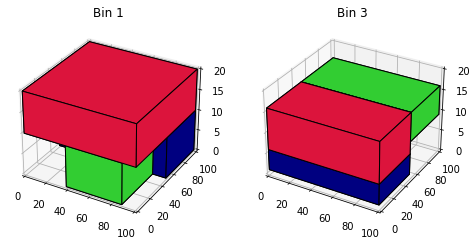

In [145]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def getSolutionBox(i):
    box = boxes[i]
    return Box(
        box.id,
        solution.get_value(x_i[i]),
        solution.get_value(y_i[i]),
        solution.get_value(z_i[i]),
        box.w,
        box.d,
        box.h,
        solution.get_value(r_i[i]),
        [solution.get_value(v_ij[i][j]) for j in J].index(1))

def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def getCubeCollection(boxes,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(boxes)
    g = []
    for box,c in zip(boxes,colors):
        g.append(cuboid_data((box["x"], box["y"], box["z"]), (box["width"], box["depth"], box["height"])))
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6), **kwargs)

def plotBox(box, ax=None,**kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    # Plotting a cube element at position pos
    if ax !=None:
        X, Y, Z = cuboid_data((box["x"], box["y"], box["z"]), (box["width"], box["depth"], box["height"]) )
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, **kwargs)
        surf.patch.set_edgecolor('black')
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, color="black", **kwargs)

colors = ["crimson","limegreen", "navy"]

if solution.is_solution_optimal():
    milpBoxes = [getSolutionBox(i).to_dict() for i in I]
    openedBins = [j for j in J if solution.get_value(u_j[j]) == 1]
    binPerRows = min(len(openedBins), 4)
    plotRows = int(len(openedBins)/binPerRows)
    fig = plt.figure(figsize=plt.figaspect(plotRows/binPerRows))
    idx = 0
    for bin in openedBins:
        idx += 1
        ax = fig.add_subplot(plotRows, binPerRows, idx, projection='3d')
        ax.set_title("Bin " + str(bin))
        ax.set_zlim(0, H)
        ax.set_ylim(0, D)
        ax.set_xlim(0, W)
        ax.add_collection3d(getCubeCollection([box for box in milpBoxes if box["bin"] == bin], colors=colors, edgecolor="k"))
else:
    print("Infeasible")

## Heuristic Solution

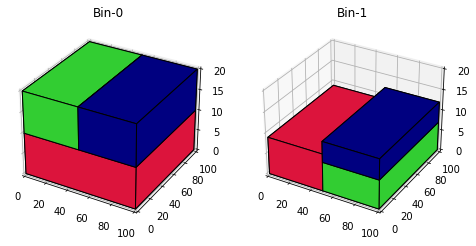

In [141]:
import requests
import time

class Problem:
    def __init__(self, W, D, H, boxes):
        self.bins = [
            {
                "id": "Bin",
                "width": W,
                "depth": D,
                "height": H,
                "maxLoad": 999.0
            }
        ]
        self.boxes = boxes
        self.configuration = {
            "layer_packing": False,
            "support_area_threshold": 0.7,
            "overflow": 0,
            "tolerance": 0
        }
        self.solution = None
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
        

prob = Problem(W, D, H, [boxes[i].to_packer_box() for i in I])
r = requests.post("http://localhost:4567/jobs", data=prob.toJSON())

jobId = r.json()["job_id"]

sol = None
while(sol == None):
    time.sleep(0.2)
    sol = requests.get("http://localhost:4567/jobs/" + str(jobId))
    if sol.status_code == 500:
        break
    if not sol.status_code == 200:
        sol = None

if sol.json()["status"] == "completed":
    solBins = sol.json()["solution"]["bins"]
    binPerRows = min(len(solBins), 4)
    plotRows = int(len(solBins)/binPerRows)
    fig = plt.figure(figsize=plt.figaspect(plotRows/binPerRows))
    idx = 0
    for bin in solBins:
        idx += 1
        ax = fig.add_subplot(plotRows, binPerRows, idx, projection='3d')
        ax.set_title(bin["id"])
        ax.set_zlim(0, H)
        ax.set_ylim(0, D)
        ax.set_xlim(0, W)
        ax.add_collection3d(getCubeCollection([box for box in bin["boxes"]], colors=colors, edgecolor="k"))